In [2]:
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch
import torch.nn.functional as F


import numpy as np
from collections import Counter

from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay


from src.word_to_embedding import WordToEmbedding

RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model and dataset

In [3]:
w2e = WordToEmbedding()

In [4]:
class LoanwordsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_to_id: dict[str, int], embeddeing_engine: WordToEmbedding):
        self.__data = data
        self.__len = self.__data.shape[0]
        
        self.__label_mapping = label_to_id
        self.__embeddeing_engine = embeddeing_engine


    def __len__(self):
        return self.__len

    def __getitem__(self, index) -> tuple[str, str]:
        entry = self.__data.iloc[index]

        word = entry['дума']
        origin = entry['произход']
        word_tensor = self.__embeddeing_engine.get_embedding(word)
        origin_tensor = self.__label_mapping[origin]

        word_tensor_shape = word_tensor.shape
        word_tensor = word_tensor.reshape((word_tensor_shape[0], 1, word_tensor_shape[1]))

        return word, word_tensor, origin, origin_tensor


In [5]:
class LoanwordClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.__hidden_size = hidden_size

        self.__i2h = nn.Linear(input_size + self.__hidden_size, self.__hidden_size).to(device)
        self.__h2h = nn.Linear(hidden_size, hidden_size).to(device)
        self.__h2h_2 = nn.Linear(hidden_size, hidden_size).to(device)
        self.__h2o = nn.Linear(hidden_size, output_size).to(device)
        self.__softmax = nn.LogSoftmax(dim=1).to(device)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor.to(device), hidden.to(device)), 1).to(device)
        hidden = F.tanh(self.__i2h(combined).to(device) + self.__h2h(hidden.to(device)).to(device)).to(device)
        hidden = F.tanh(hidden + self.__h2h_2(hidden.to(device)).to(device)).to(device)
        output = self.__h2o(hidden).to(device)
        output = self.__softmax(output).to(device)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.__hidden_size)

In [6]:
def category_from_output(output, id_to_label):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return id_to_label[str(category_i)], category_i

In [7]:
def test_loop(model: LoanwordClassifier, test_dataloader, id_to_label):
    predicted_ids = []
    actual_ids = []
    for word, word_tensor, label, label_tensor in tqdm(test_dataloader):
        word_tensor = word_tensor[0]

        hidden = model.init_hidden()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)

        predicted_label, predicted_label_id = category_from_output(output, id_to_label)
        # print(predicted_label, predicted_label_id)
        predicted_ids.append(predicted_label_id)
        actual_ids.append(label_tensor)
    
    return predicted_ids, actual_ids

In [27]:
amount_of_bg_words = '5'

path = f'/mnt/d/Projects/masters-thesis/data/loanwords_{amount_of_bg_words}k_bg_words.csv'
data = pd.read_csv(path)

with open(f'models/label-to-id-2024-05-27-1024hidden-15epochs-{amount_of_bg_words}kbgwords.json') as fp:
    label_to_id = json.load(fp)

with open(f'models/id-to-label-2024-05-27-1024hidden-15epochs-{amount_of_bg_words}kbgwords.json') as fp:
    id_to_label = json.load(fp)

# Running the model with normal labels 
train_data, test_data = train_test_split(data, random_state=RANDOM_STATE)


test_dataset = LoanwordsDataset(test_data, label_to_id, embeddeing_engine=w2e)
test_dataloader = DataLoader(test_dataset)

model = LoanwordClassifier(input_size=512, hidden_size=1024, output_size=len(label_to_id))

state_dict_path = f'models/classifier-2024-05-27-1024hidden-15epochs-{amount_of_bg_words}kbgwords.pth'
model.load_state_dict(torch.load(state_dict_path))

<All keys matched successfully>

In [28]:
predicted, actual = test_loop(model, test_dataloader, id_to_label)
actual = [t.item() for t in actual]

100%|██████████| 2542/2542 [00:09<00:00, 258.62it/s]


## Per class

In [29]:
print(f'Accuracy: {accuracy_score(actual, predicted):.3f}')
print(f'Precison: {precision_score(actual, predicted, average="weighted"):.3f}')
print(f'F1 score: {f1_score(actual, predicted, average="weighted"):.3f}')

Accuracy: 0.590
Precison: 0.553
F1 score: 0.565


/home/lyubolp/detecting-loanwords/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
matrix = np.zeros((len(label_to_id), len(label_to_id)), dtype=np.int16)

for a, p in zip(actual, predicted):
    matrix[a][p] += 1

/tmp/ipykernel_7174/2860072006.py:1: RuntimeWarning: invalid value encountered in divide
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


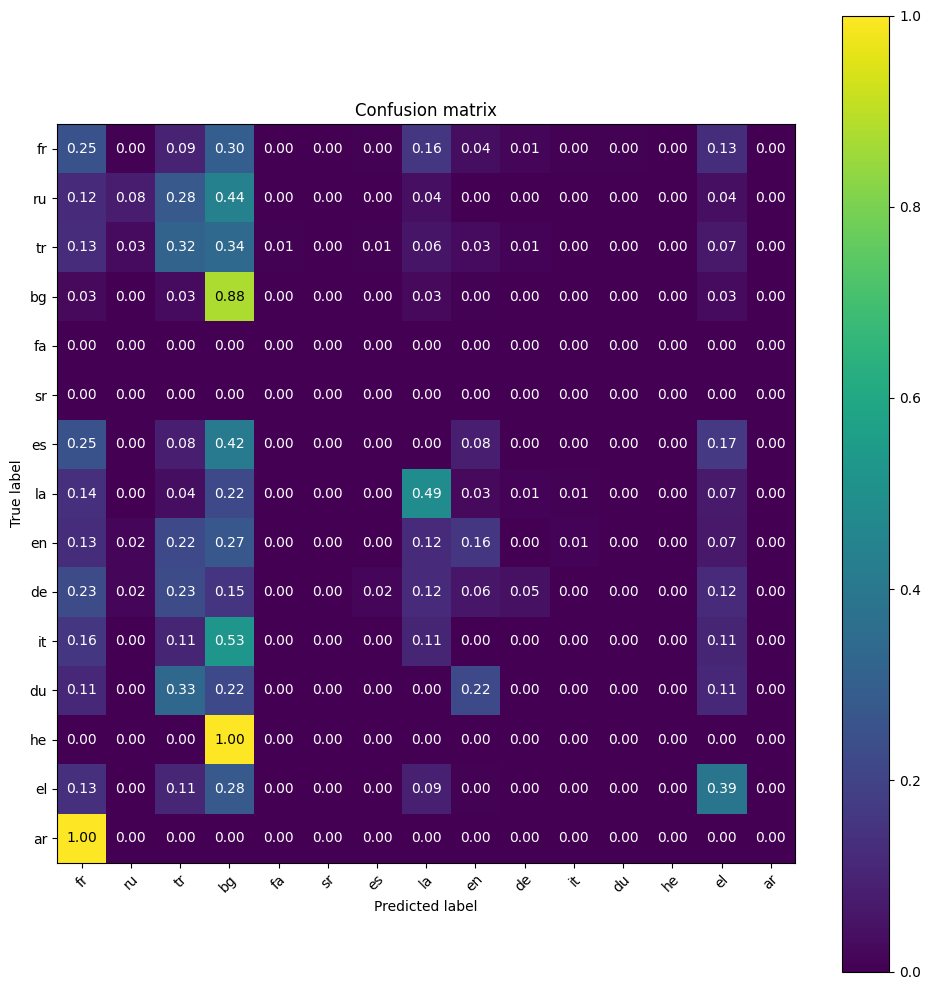

In [31]:
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.nan_to_num(matrix)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(matrix.shape[1]),
        yticks=np.arange(matrix.shape[0]),
        xticklabels=list(label_to_id.keys()), yticklabels=list(label_to_id.keys()),
        title='Confusion matrix',
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# fmt = '.2f' if normalize else 'd'
fmt = '.2f'
thresh = 0.7
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, format(matrix[i, j], fmt),
                ha="center", va="center",
                color="black" if matrix[i, j] > thresh else "white")
fig.tight_layout()


## Binary

In [32]:
predicted_binary = [0 if item == label_to_id['bg'] else 1 for item in predicted]
actual_binary = [0 if item == label_to_id['bg'] else 1 for item in actual]

In [33]:
print(f'Accuracy: {accuracy_score(actual_binary, predicted_binary):.3f}')
print(f'Precison: {precision_score(actual_binary, predicted_binary):.3f}')
print(f'Recall: {recall_score(actual_binary, predicted_binary):.3f}')
print(f'F1 score: {f1_score(actual_binary, predicted_binary):.3f}')

Accuracy: 0.797
Precison: 0.863
Recall: 0.722
F1 score: 0.786


In [34]:
binary_matrix = np.zeros((2, 2), dtype=np.int16)

for a, p in zip(predicted_binary, actual_binary):
    binary_matrix[a][p] += 1

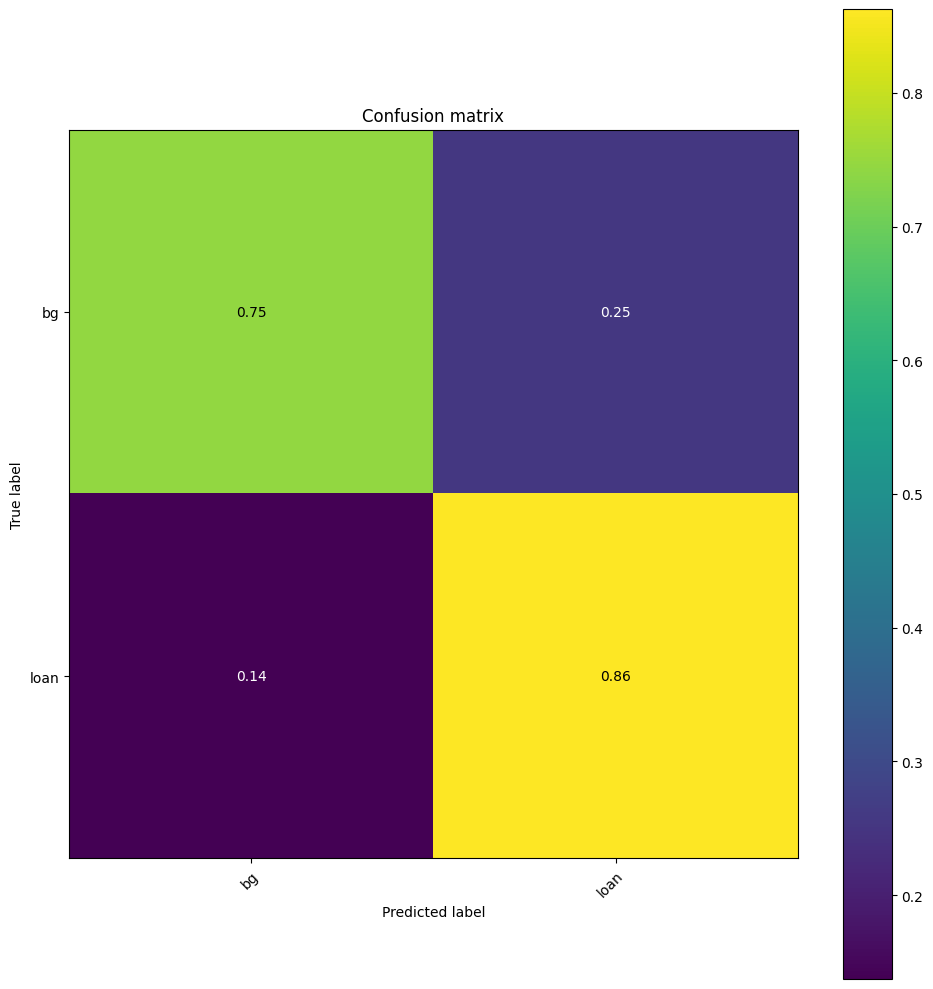

In [35]:
binary_matrix = binary_matrix.astype('float') / binary_matrix.sum(axis=1)[:, np.newaxis]
binary_matrix = np.nan_to_num(binary_matrix)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(binary_matrix, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks and label them with the respective list entries
ax.set(xticks=np.arange(binary_matrix.shape[1]),
        yticks=np.arange(binary_matrix.shape[0]),
        xticklabels=['bg', 'loan'], yticklabels=['bg', 'loan'],
        title='Confusion matrix',
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# fmt = '.2f' if normalize else 'd'
fmt = '.2f'
thresh = 0.7
for i in range(binary_matrix.shape[0]):
    for j in range(binary_matrix.shape[1]):
        ax.text(j, i, format(binary_matrix[i, j], fmt),
                ha="center", va="center",
                color="black" if binary_matrix[i, j] > thresh else "white")
fig.tight_layout()
